In [7]:
import numpy as np
import subprocess
from IPython.display import clear_output

# Simulation parameters
simDuration = 200  # seconds
simTimeStep = 0.005  # seconds

samplingStartTime = 0  # seconds
samplingPeriod = simTimeStep  # seconds
numSamples = (simDuration-samplingStartTime)/samplingPeriod

# Microfluidic channel parameters
h_ch = 5e-6  # meters
w_ch = 10e-6  # meters
A_ch = h_ch * w_ch  # square meters
u = 10e-6  # meters per second
x_r = 1e-3  # meters
t_d = x_r / u  # seconds

# Molecule parameters
D_0 = 2e-11  # square meters per second
D = (1 + ((8.5 * u**2 * h_ch**2 * w_ch**2) / (210 * D_0**2 * (h_ch**2 + 2.4 * h_ch * w_ch + w_ch**2)))) * D_0
K_b_m = 2e-17  # cubic meters per second
K_u_m = 1  # per second
K_D_m = K_u_m / K_b_m  # cubic meters

# Receiver parameters
N_r = 200
l_gr = 5e-6  # meters
w_gr = w_ch
A_gr = l_gr * w_gr  # square meters

# Geometry of the microfluidic channel
l_ch = 200e-6  # meters
vol_ch = w_ch * h_ch * l_ch  # cubic meters

# Modulation and bitstream generation
N_1 = 10000
N_2 = 200
Nt = [N_2, N_1]  # number of transmitted molecules for bit [0, 1]

numSymbol = 10
bitstream = np.random.randint(2, size=numSymbol)

# Calculate ligand concentration samples
N_m_array = np.zeros(numSymbol)
N_m_array[bitstream == 0] = Nt[0]
N_m_array[bitstream == 1] = Nt[1]

c_m_peak_array = N_m_array / (A_ch * np.sqrt(4 * np.pi * D * t_d))
cLigand_array = c_m_peak_array * 1e-18  # (1/um^3)
numLigand_array = np.round(cLigand_array * vol_ch * 1e18).astype(int)  # Convert volume to cubic micrometers

# Check sampling parameters
if samplingStartTime > simDuration:
    print('Error: increase the duration of the simulation!')
# Instead of directly comparing the remainder to 0,
# check if it's smaller than a very small threshold
if samplingPeriod % simTimeStep > 1:  # 1e-9 is an example threshold, adjust as needed
    print('Error: enter a new samplingPeriod that is integer multiple of simTimeStep!')

else:
    samplingWindowLength = numSamples * samplingPeriod
    if samplingStartTime + samplingWindowLength > simDuration:
        print('Error: Sampling extends beyond the simulation duration, decrease number of samples, sampling period, sampling start time, OR increase simulation duration.')
    else:
        print(f'Starting simulations... \n Sampling Window Length = {samplingWindowLength} seconds \n Sampling Frequency = {1/samplingPeriod} Hz')

        for i in range(numSymbol):
            # Prepare Smoldyn command with parameters
            command = f"smoldyn config.txt -wt --define simDuration={simDuration} " \
                    f"--define simTimeStep={simTimeStep} " \
                    f"--define numLigand={numLigand_array[i]} --define numReceptor={N_r} " \
                    f"--define diffLigand={D*1e12} " \
                    f"--define kBindLigand={K_b_m*1e18} --define kUnbindLigand={K_u_m} " \
                    f"--define w_ch={w_ch*1e6} " \
                    f"--define h_ch={h_ch*1e6} --define l_ch={l_ch*1e6} " \
                    f"--define l_rx={l_gr*1e6} --define w_rx={w_gr*1e6} " \
                    f"--define x_rx={((l_ch/2)*1e6)} --define index={i+1} " \
                    f"--define x_comp=100 --define y_comp=3 --define z_comp=5"
                    
            
            # display(command)

            # Execute command and wait for it to complete
            result = subprocess.run(command, shell=True, check=True)

            clear_output(wait=True) 
            print(f'Starting simulations... \n Sampling Window Length = {samplingWindowLength} seconds \n Sampling Frequency = {1/samplingPeriod} Hz')
            print(f"Simulation {i+1}/{numSymbol} completed.")


Starting simulations... 
 Sampling Window Length = 200.0 seconds 
 Sampling Frequency = 200.0 Hz
Simulation 10/10 completed.


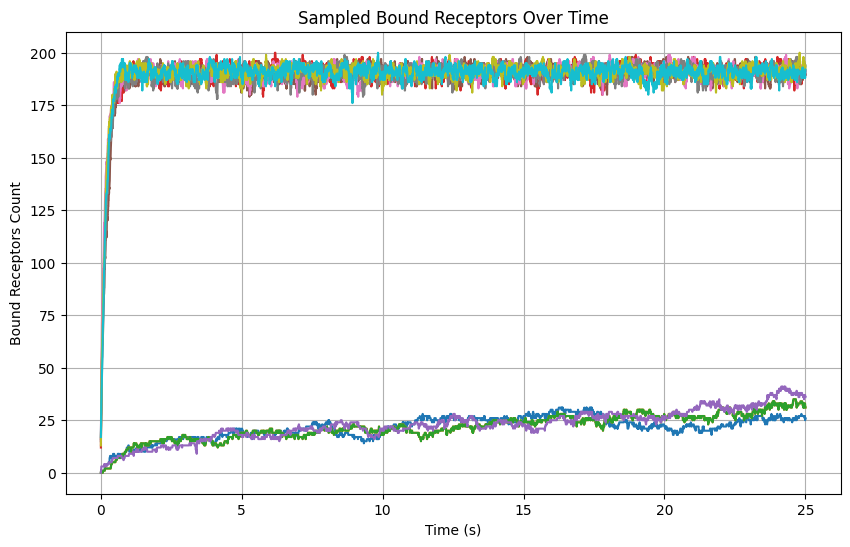

In [5]:
# plot them as replicates
import matplotlib.pyplot as plt
import numpy as np

# Assuming these variables are defined: numSymbol, samplingPeriod, simTimeStep, samplingStartTime, simDuration

# Correct calculation of numSamples
numSamples = int((simDuration - samplingStartTime) / samplingPeriod)

# Plotting
plt.figure(figsize=(10, 6))

for i in range(numSymbol):
    outputfilename = f'configout_symbol_id_{i+1}_moleculecount.txt'
    try:
        # Load data
        molcount = np.loadtxt(outputfilename, delimiter=' ')
    except IOError:
        print(f"File {outputfilename} not found. Skipping symbol {i+1}.")
        continue
    
    # Filtering data based on time range
    filtered_data = molcount[(molcount[:, 0] >= samplingStartTime) & (molcount[:, 0] <= simDuration)]
    
    # Downsampling: Calculate effective downsampling factor
    downsampling_factor = int(samplingPeriod / simTimeStep)
    if downsampling_factor < 1:
        downsampling_factor = 1
    sampled_data = filtered_data[::downsampling_factor]
    
    # Plotting
    if len(sampled_data) > 0:
        plt.plot(sampled_data[:, 0], sampled_data[:, 3], label=f'Symbol {i+1}')  # Adjust column index if needed
    else:
        print(f"No data available for plotting for symbol {i+1}.")

plt.title('Sampled Bound Receptors Over Time')
plt.xlabel('Time (s)')
plt.ylabel('Bound Receptors Count')
plt.grid(True)
plt.show()


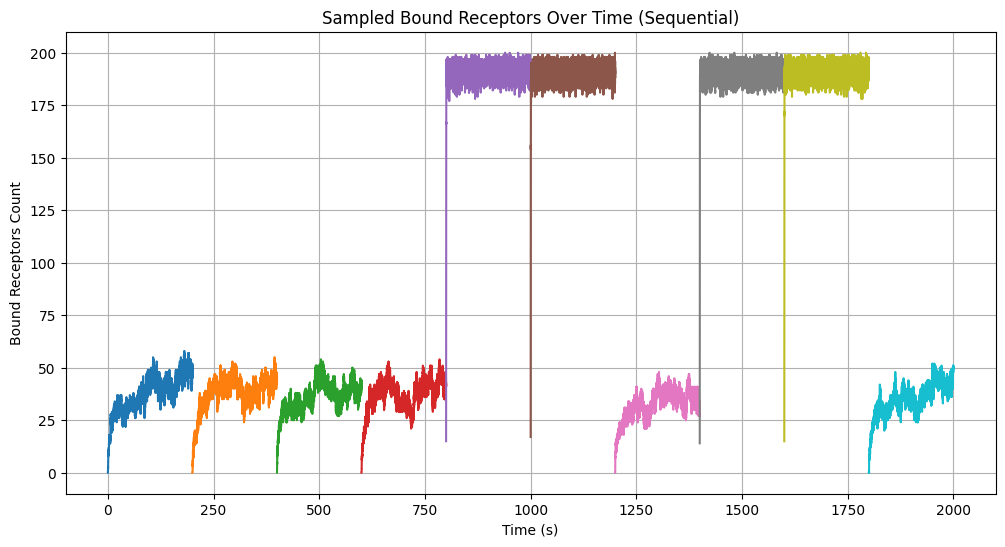

In [8]:
# plot them sequentially
import matplotlib.pyplot as plt
import numpy as np

# Assuming these variables are defined: numSymbol, samplingPeriod, simTimeStep, samplingStartTime, simDuration

# Correct calculation of numSamples
numSamples = int((simDuration - samplingStartTime) / samplingPeriod)

# Plotting
plt.figure(figsize=(12, 6))  # Adjusted for potentially wider plots

total_duration = 0  # Initialize total duration to accumulate offsets

for i in range(numSymbol):
    outputfilename = f'configout_symbol_id_{i+1}_moleculecount.txt'
    try:
        # Load data
        molcount = np.loadtxt(outputfilename, delimiter=' ')
    except IOError:
        print(f"File {outputfilename} not found. Skipping symbol {i+1}.")
        continue
    
    # Filtering data based on time range
    filtered_data = molcount[(molcount[:, 0] >= samplingStartTime) & (molcount[:, 0] <= simDuration)]
    
    # Downsampling: Calculate effective downsampling factor
    downsampling_factor = int(samplingPeriod / simTimeStep)
    if downsampling_factor < 1:
        downsampling_factor = 1
    sampled_data = filtered_data[::downsampling_factor]
    
    # Offset x-axis data for sequential plotting
    if len(sampled_data) > 0:
        # Add total_duration to the time data for sequential plotting
        plt.plot(sampled_data[:, 0] + total_duration, sampled_data[:, 3], label=f'Symbol {i+1}')  # Adjust column index if needed
        total_duration += simDuration  # Increase total_duration by the duration of one simulation
    else:
        print(f"No data available for plotting for symbol {i+1}.")

plt.title('Sampled Bound Receptors Over Time (Sequential)')
plt.xlabel('Time (s)')
plt.ylabel('Bound Receptors Count')
# plt.legend()
plt.grid(True)
plt.show()
